# Using mobile device behavior data to predict users' gender and age
Haofeng Kong   NUID: 001211728


# Abstract
Iris recognition technology is based on the identification of the mobile user's behavior. The mobile user's behavior consists of phone brand, phone model, application download and other parts. Smart mobile devices, especially mobile phones, with more and more, more and more accurate sensor, using the sensor data, combined with machine learning and deep learning ability, can recognize the user's behavior, and the user's behavior data can be used like UBI, anti-cheat solutions, many fields such as fitness class App, can also be used as a Real time customer engagement important reference data. This paper proposed identification of the mobile user's behavior based on phone brand,phone model and app classification, the accuracy of user behavior depends on the accuracy of classification. So as to verify the SVM can get higher accuracy of iris classification than other two methods logisitic regression and CNN, the three experiment was carried out about model and brand classification .

# Introduction:
user behavior recognition technology is a kind of human biological recognition technology. The appearance of the user behavior consists of two parts: the gender, the age. The gender, which is the sexuality part of the user, accounts for about 30% of the total area; the center of the eye is the pupil, which accounts for about 5%; the iris is located between the sclera and the pupil and contains the most abundant texture information, occupying 65%. From the appearance, it is composed of many glands, folds, pigment spots, etc. It is one of the most unique structures in the human body. The formation of the iris is determined by genetics, and the human gene expression determines the morphology, physiology, color and overall appearance of the iris. After about eight months of development, the iris has basically developed to a sufficient size and entered a relatively stable period. Unless unusual abnormalities, physical or mental trauma, may cause changes in the appearance of the iris, the morphology of the iris can remain unchanged for decades. On the other hand, the iris is visible to the outside but at the same time belongs to the internal tissue behind the cornea. To change the appearance of the iris, very delicate surgery is required and the risk of visual impairment is risked. The uniqueness, stability and immutability of the iris are the material basis for the identification of the iris. 

# DataSet
The dataset come from https://www.kaggle.com/c/talkingdata-mobile-user-demographics/data


# data preprocess
The phone brand and phone model are preprocessed with Matlab, the code is already documented in a word file. I have uploaded this notebook, a word file and two .mat file with image features matrix that already been processed in a floder. 

# SVM, LOGITISIC, cnn
k-nearest neighbors algorithm is a non-parametric method used for classification and regression. In K-NN algorithms there are brute, kd_tree and ball_tree. In this research, the algorithms used is kd_tree. The k-d tree is a binary tree in which every node is a k-dimensional point.

In [38]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from sklearn.feature_selection import VarianceThreshold
import math

In [39]:
datadir="./dataset"

load data 

In [40]:
gender_age_train = pd.read_csv(os.path.join(datadir, 'gender_age_train.csv'),index_col='device_id')
gender_age_test = pd.read_csv(os.path.join(datadir, 'gender_age_test.csv'),index_col='device_id')
events = pd.read_csv(os.path.join(datadir, 'events.csv'),usecols=['device_id', 'event_id'], index_col='event_id')
app_events = pd.read_csv(os.path.join(datadir,'app_events.csv'), usecols=['event_id','app_id','is_active'])
phone_brand_device_model = pd.read_csv(os.path.join(datadir, 'phone_brand_device_model.csv'))
app_labels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

In [41]:
# how dataset look like and their relation

In [42]:
%%html
<img style="float: right;" src="Picture.png" width =80%>

# remove duplicate data

In [43]:
phone_brand_device_model = phone_brand_device_model.drop_duplicates('device_id').set_index('device_id')

# phone brand feature engineering
# change brand to numbers using lable encoder

In [44]:
gender_age_test['testrow'] = np.arange(gender_age_test.shape[0])
gender_age_train['trainrow'] = np.arange(gender_age_train.shape[0])

In [45]:
brand_label_encoder = LabelEncoder()
brand_label_encoder.fit(phone_brand_device_model['phone_brand'].values)
phone_brand_device_model['brand'] = \
        brand_label_encoder.transform(phone_brand_device_model['phone_brand'].values)

In [46]:
gender_age_train['brand'] = phone_brand_device_model['brand']
gender_age_test['brand'] = phone_brand_device_model['brand']

# Sparse matrix in certain types of data, the most notable is the record events occur or count.

In [47]:
from scipy.sparse import csr_matrix, hstack

In [48]:
# make a sparse matrix，row is device,column is each brand，
Xtr_brand = csr_matrix((np.ones(gender_age_train.shape[0]), (gender_age_train['trainrow'], gender_age_train['brand'])))
Xte_brand = csr_matrix((np.ones(gender_age_test.shape[0]), (gender_age_test['testrow'], gender_age_test['brand'])))
print(Xtr_brand.shape, Xte_brand.shape)

(74645, 131) (14933, 129)


# get phone model feature 

In [49]:
#  merge the phone brand and phone mode string 

In [50]:
phone_brand_device_model['brand_model'] = \
        phone_brand_device_model['phone_brand'].str.cat(phone_brand_device_model['device_model'])

In [51]:
# change model to numbers using lable encoder

In [52]:
model_label_encoder = LabelEncoder()

In [53]:
model_label_encoder.fit(phone_brand_device_model['brand_model'].values)

LabelEncoder()

In [54]:
phone_brand_device_model['brand_model_label_code'] = \
        model_label_encoder.transform(phone_brand_device_model['brand_model'].values)

In [55]:
gender_age_train['brand_model_label_code'] = phone_brand_device_model['brand_model_label_code']

In [56]:
gender_age_test['brand_model_label_code'] = phone_brand_device_model['brand_model_label_code']

# make sparse matrix

In [57]:
Xtr_model = csr_matrix((np.ones(gender_age_train.shape[0]), 
                       (gender_age_train.trainrow, gender_age_train.brand_model_label_code)))
Xte_model = csr_matrix((np.ones(gender_age_test.shape[0]), 
                       (gender_age_test.testrow, gender_age_test.brand_model_label_code)))

In [58]:
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (14933, 1663)


In [59]:
app_encoder = LabelEncoder()
app_encoder.fit(app_events['app_id'].values)
app_events['app'] = \
        app_encoder.transform(app_events['app_id'].values)

In [60]:
%%html
<img style="float: right;" src="Picture.png" width =80%>

In [61]:
# merge app and  app_events
device_apps = app_events.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
# merge same spp，record every app show up times
device_apps = device_apps.groupby(['device_id','app'])['app'].agg(['size'])
# Will continue to merger with ga_train and ga_test device_apps (combined line mark only)
#, which can be classified by trainrow and testrow get their corresponding

device_apps = device_apps.merge(gender_age_train[['trainrow']], how='left', left_index=True, right_index=True)
device_apps = device_apps.merge(gender_age_test[['testrow']], how='left', left_index=True, right_index=True)
device_apps = device_apps.reset_index() 
#Turned out to be the device_id and app is set to line mark, now will be resumed its properties

#  below make a sparse matrix，row is device,column is each app，


In [62]:
napps = len(app_encoder.classes_)
d = device_apps.dropna(subset=['trainrow']) # Take out a trainrow (testrow NaN) data
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d['trainrow'], d['app'])), shape=[gender_age_train.shape[0],napps])
d = device_apps.dropna(subset=['testrow']) 
Xte_app = csr_matrix((np.ones(d.shape[0]), (d['testrow'], d['app'])), shape=[gender_age_test.shape[0],napps])
# due to app is greater than the number of devices have brand information, number of devices that not all of the device has a corresponding brand
print(Xtr_app.shape, Xte_app.shape)

(74645, 19237) (14933, 19237)


# Because app_labels there are some app is not appear in the events, so take out only those appeared


In [63]:
# join The app code to app_labels
app_labels = app_labels.loc[app_labels.app_id.isin(app_events.app_id.unique())]
app_labels['app'] = app_encoder.transform(app_labels['app_id'])
# label number again
label_encoder = LabelEncoder().fit(app_labels['label_id'])
app_labels['label'] = label_encoder.transform(app_labels['label_id'])

# merge device_app and app_labels two table and use group by to make a small new group  


In [64]:
device_labels = (device_apps[['device_id','app']]
                .merge(app_labels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gender_age_train[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gender_age_test[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())

In [65]:
#still do sparse matrix

In [66]:
nlabels = len(label_encoder.classes_) 
# Behind csr_matrix below to add a shape, or may be due to the cause of the intermediate function selection that there is no consistent size
d = device_labels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), shape=(gender_age_train.shape[0],nlabels))
d = device_labels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), shape=(gender_age_test.shape[0],nlabels))
print(Xtr_label.shape, Xte_label.shape)

(74645, 492) (14933, 492)


# merge feature

In [67]:
train_feat = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')

In [68]:
test_feat = hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')

In [69]:
# Normalization of feature range for svm and logisitic regression

In [70]:
from sklearn.preprocessing import normalize
train_feat_scaled = normalize(train_feat, norm='l1', axis=1)

In [71]:
test_feat_scaled = normalize(test_feat, norm='l1', axis=1)

In [72]:
#choose feature using variance 

In [73]:
select = VarianceThreshold(threshold=(.001*(1-.8)))
test_feat_scaled_select=select.fit_transform(test_feat_scaled)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


# cause we use sparse matrix and it is a singular matrix and pca usually solve linear problem so we can't use pca and only using svd to decrase dimension to remove some error,

In [74]:
from sklearn.decomposition import TruncatedSVD

In [75]:
#define how many feature we want

In [76]:
svd=TruncatedSVD(41)

In [77]:
train_feat_scaled_select_svd = svd.fit_transform(train_feat_scaled)

In [78]:
test_feat_scaled_select_svd = svd.fit_transform(test_feat_scaled_select)

In [79]:
print("finish feature engineering")

finish feature engineering


In [80]:
#After processing,  feature dimension of each sample

In [81]:
train_feat_scaled_select_svd.shape[1] 

41

In [82]:
#although we change the brand to number it is easy to calculate and lassify but in some case, classifier  will
#think these number have law or order, actually it not. so we should use sparse matrix to lower their regularity
#and it will help us to classify ，have two ways to change string to The binary encoding：onehot and labelbinaarizer
#and this time, one hot can't change m23-26 to float number so we use 
#LabelBinarizer

In [83]:
from sklearn.preprocessing import OneHotEncoder

In [84]:
from sklearn.preprocessing import LabelBinarizer
target_encoder = LabelEncoder().fit(gender_age_train['group'])
target_encoder1 = LabelBinarizer(sparse_output=True).fit(gender_age_train['group'])
Y = target_encoder1.transform(gender_age_train['group'])
nclasses = len(target_encoder1.classes_)
group_lable_encoder=LabelEncoder()
group_lable_encoder.fit(gender_age_train['group'].values)
ytrain = group_lable_encoder.transform(gender_age_train['group'].values)
ytest= target_encoder.transform(gender_age_test['group'])
#app_labels
print(nclasses)

12


In [85]:
from scipy import sparse
train_feat_scaled_select_svd = sparse.csr_matrix(train_feat_scaled_select_svd)

In [86]:
X_test = train_feat[70001:]
y_test = Y[70001:]

X_train = train_feat[:70001]
y_train = Y[:70001]

In [90]:
y_train.shape[0]

70001

In [ ]:
import tensorflow as tf
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
        return tf.Variable(tf.constant(0.05, shape=[shape]))

In [119]:

# execute a convolution
def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x, W, [1, 1, 1, 1], padding='VALID')


# A one-dimensional Max pooling in convolution output layer
def apply_max_pool(x, kernel_size, stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1],
                          strides=[1, 1, stride_size, 1], padding='VALID')


In [120]:
import tensorflow as tf
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
        return tf.Variable(tf.constant(0.05, shape=[shape]))

N = 100
M = 30
# Create the model
x = tf.placeholder(tf.float32, [None, 21527])
W1 = weight_variable([21527, N])
b1 = bias_variable([N])
#y1 = tf.nn.relu(tf.matmul(x, W1) + b1)
y1 = tf.nn.softplus(tf.matmul(x, W1) + b1)
keep_prob1 = tf.placeholder("float")
fc1_drop = tf.nn.dropout(y1, keep_prob1)

W2 = weight_variable([N, M])
b2 = bias_variable([M])
#y2 = tf.nn.relu(tf.matmul(y1, W2) + b2)
y2 = tf.nn.softplus(tf.matmul(y1, W2) + b2)
keep_prob2 = tf.placeholder("float")
fc2_drop = tf.nn.dropout(y1, keep_prob2)

W3 = weight_variable([M, 12])
b3 = bias_variable([12])
y = tf.matmul(y2, W3) + b3

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 12])

# The raw formulation of cross-entropy,
#
#   tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.nn.softmax(y)),
#                                 reduction_indices=[1]))
#
# can be numerically unstable.
#
# So here we use tf.nn.softmax_cross_entropy_with_logits on the raw
# outputs of 'y', and then average across the batch.
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
#reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(0.0001), 
                                             #weights_list=[W1, W2])
#mse = tf.reduce_sum(tf.square(y_ -  y)) mean squared error
#loss =mse
loss = cross_entropy
#train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
#tf.zeros_initializer().run()
#tf.glorot_normal_initializer().run

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [121]:
j0 = 30
i0 = 100
n0 = 100
# Train
for j in range(j0):
    for i in range(i0):
        shuffle = np.random.choice(7000, size=100, replace=False)
        sess.run(train_step, feed_dict={x: X_train[shuffle].toarray(), 
                                        y_: y_train[shuffle].toarray(), 
                                        keep_prob1:0.5, 
                                        keep_prob2:0.5})
    if j%5==0:
        # Test trained model
        #shuffle_test = np.random.choice(74645, size=10000, replace=False)
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        #print('epoch:', j, sess.run(cross_entropy, feed_dict={x: X[shuffle_test].toarray(),
                                                              #y_: Y[shuffle_test].toarray()}))
        print('epoch:', j, sess.run(cross_entropy, feed_dict={x: X_test.toarray(),
                                                              y_: y_test.toarray(), 
                                                              keep_prob1:1.0, 
                                                              keep_prob2:1.0}))

epoch: 0 2.4471262
epoch: 5 2.451494
epoch: 10 2.4412522
epoch: 15 2.4206052
epoch: 20 2.4163818
epoch: 25 2.4449718


In [109]:
from sklearn.model_selection import GridSearchCV

In [110]:
# using cross validation to get best model and default cv is 5
def get_best_model(model, X_train, y_train, params, cv=5):  
    clf = GridSearchCV(model, params, cv=cv)
    clf.fit(X_train, y_train)
    return clf.best_estimator_                                 

In [111]:
param_grid = [{'C': [1e-3, 1e-2, 1e-1, 1, 10, 100]}] #Specify 6  hyperparameters to select the best model less  number the stronger standarization

In [112]:
model = LogisticRegression()

In [113]:
bestmodel = get_best_model(model,train_feat_scaled_select_svd,ytrain,param_grid, cv=3)

In [114]:
y_pred_lr = bestmodel.predict_proba(test_feat_scaled_select_svd)

In [116]:
log_loss(ytest, y_pred_lr)

2.4235046261912916

In [ ]:
# svm model implement

In [74]:
svm_param_grid = [{'C': [1e-2, 1e-1, 1, 10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},]

In [ ]:
# set probility true so we can get the Predicted Probability

In [75]:
svm_model = svm.SVC(probability=True)

In [76]:
best_svm_model = get_best_model(svm_model,train_feat_scaled_select_svd,ytrain,svm_param_grid, cv=3)

In [77]:
y_pred_svm = best_svm_model.predict_proba(test_feat_scaled_select_pca)

In [78]:
log_loss(ytest, y_pred_svm)

2.417528026875335

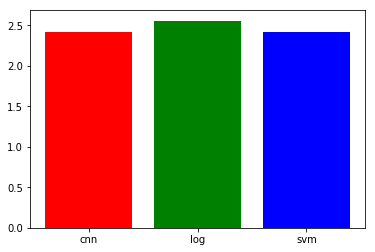

In [3]:
import matplotlib.pyplot as plt
model_list = ['cnn','logi','svm']
mean_logloss_list = [ 2.4238482,2.5588730537839792,2.417528026875335]
plt.bar(range(len(mean_logloss_list)), mean_logloss_list,color='rgb',tick_label=model_list)
plt.show()

# References
[1] J.G. Daugman. "High confidence visual recognition of persons by a test of statistical independence Pattern Anal". Mach. Intell. IEEE Trans., 15 (11) (1993), pp. 1148-1161
[2] Lakshmi Sandhana. "Iris scanner could tell your race and gender". New scientist. 12 October 2011
[3] Nadia Othman,Bernadette Dorizzi,Sonia Garcia-Salicetti. "OSIRIS: An open source iris recognition software".Pattern Recognition Letters. 15 October 2016
[4] S.Jayalakshmi, M.Sundaresan. "A Study of Iris Segmentation Methods using Fuzzy CMeans and K-Means Clustering Algorithm". International Journal of Computer Applications (0975 – 8887) Volume 85 – No 11, January 2014
[5] Altman, N. S. (1992). "An introduction to kernel and nearest-neighbor nonparametric regression". The American Statistician. 46 (3): 175–185. 
[6] Bentley, J. L. (1975). "Multidimensional binary search trees used for associative searching". Communications of the ACM. 18 (9): 509. 
[7] Cortes, Corinna; Vapnik, Vladimir N. (1995). "Support-vector networks". Machine Learning. 20 (3): 273–297.
[8] Venables, W. N.; Ripley, B. D. (2002). Modern Applied Statistics with S (4th ed.). Springer Verlag. ISBN 0-387-95457-0.
[9] Tony F. Chan, Gene H. Golub, Randall J. LeVeque. "Updating Formulae and a Pnirwise Algorithm for Computing Sample Variances". STAN-CS-79-773. November 1979.


# Result
We can see that the best performing iris race image classification method is SVM with LGBP feature extraction. Meanwhile, SVM classifier with LGBP feature extraction can reach 99.00% for accuracy, which is more superior than LDA, KNN and NB. The results validate our initial vision。


# Defect of SVM algorithm

SVM algorithm is difficult to implement for large-scale training samples, since SVM uses quadratic programming to solve support vectors, solving quadratic programming involves the calculation of m-order matrices (m is the number of samples). When the number of m is large, the storage and calculation of the matrix will consume a large number of machine's memory and operation time.

Also, classical support vector machine algorithm only gives binary classification algorithm, but in the practical application of data mining, generally to solve the multiclass classification problems.

# License

The code in the document by haofeng kong is licensed under the MIT License
https://opensource.org/licenses/MIT

MIT License

Copyright (c) 2018 mingguan liu and haofeng kong

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.